# Spencer Hallyburton
## Collaborator: Salvador Barragan

## APMTH 207: Advanced Scientific Computing: 
## Homework #6
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

In [1]:
import numpy as np
import scipy
import scipy.stats
from numpy.random import permutation
import tqdm
import functools
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from operator import add
import warnings
from collections import Counter


## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

In [2]:
# Define hamming distance:
def dhamm(omega, theta):
    return sum(scipy.not_equal(omega,theta))
    
# Define probability of a particular guess:
def p_guess(lam, theta, omega=[1,2,3,4,5]):
    return np.exp(-lam*dhamm(omega,theta))

# Define metropolis algorithm:
def metropolis(p, qdraw, nsamp, xinit):
    #samples = np.empty(nsamp)
    samples = []
    naccept = 0
    x_prev = xinit
    for i in tqdm.tqdm(range(nsamp)):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples.append(tuple(x_star))
            x_prev = x_star
            naccept += 1
        else:#we always get a sample
            samples.append(tuple(x_prev))
            
    print('Acceptance Ratio: %.4f' % (naccept/nsamp))
    return samples, naccept/nsamp

# Define the proposal function:
def proposal(xstate):
    return permutation(xstate)

In [3]:
# Define plotting functions
def make_plots(hvals):
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    # Make a trace plot over the history:
    ax[0].plot(hvals)
    ax[0].set_title('Trace Plot of Hash Value Movement')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Hash Value')

    # Plot histogram of movie guesses in order:
    ax[1].hist(hvals, bins = 500)
    ax[1].set_xlabel('Hash Value of Ranking Order')
    ax[1].set_ylabel('Number of Occurrences')
    ax[1].set_title('Histogram Of Movie Rankings')
    
    plt.tight_layout()
    plt.show()
    
# Define method to extract best sets
def extract_best(hvals, samples):
    # Get the 5 most probable ranking orders:
    count = Counter(hvals)
    comm = count.most_common(5)

    # Map most common back to their tuples --> this is super inefficient, I think, but it works
    hval_idx = []
    best_tuples = []
    for val, occ in comm:
        np.where(hvals==val)
        hval_idx = hvals.index(val)
        best_tuples.append((samples[hval_idx], occ))
    return(best_tuples)

In [4]:
# Create an initial state and run the metropolis
burn = 0
xinit = proposal([1,2,3,4,5])

100%|██████████| 500/500 [00:00<00:00, 12480.00it/s]

LAMBDA: 0.2
Acceptance Ratio: 0.8900


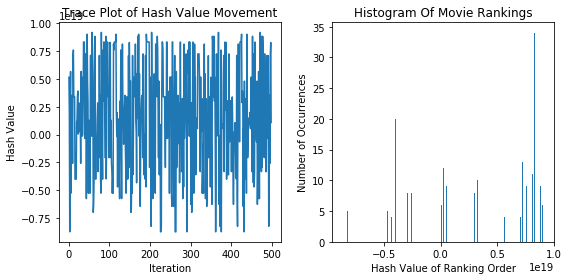

100%|██████████| 500/500 [00:00<00:00, 10604.91it/s]

LAMBDA: 0.5
Acceptance Ratio: 0.6700


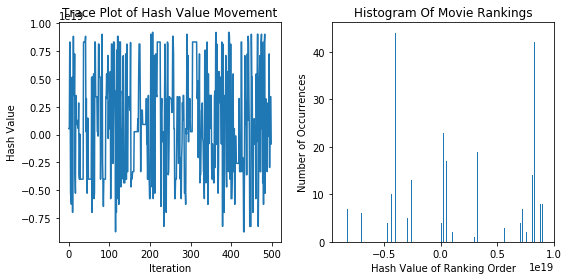

100%|██████████| 500/500 [00:00<00:00, 11693.46it/s]

LAMBDA: 1.0
Acceptance Ratio: 0.5040


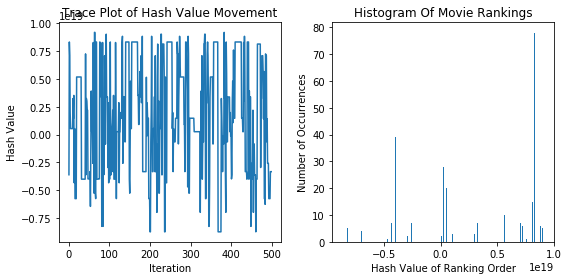

In [5]:
# Run metropolis over lambdas
lam = [0.2, 0.5, 1.0]
nsamp = 500
best_movies = []
samps = []
for i,lam_val in enumerate(lam):
    print('LAMBDA:', lam_val)
    p_partial = functools.partial(p_guess, lam_val)
    samps_temp, acc_rat = metropolis(p_partial, proposal, nsamp, xinit)
    samps.append(samps_temp)
    hvals = list(map(hash, samps_temp))
    
    # Make the plots
    make_plots(hvals)
    
    # Get the top 5 values
    best_movies.append( extract_best(hvals, samps_temp) )

In [6]:
# Print out the top 5 best parameters
omega=[1,2,3,4,5]
for i,best in enumerate(best_movies):
    print('For lambda=%.1f, common ranks (occurrences) are:'%lam[i])
    print(best)
    dist = []
    for guess in best:
        dist.append(dhamm(omega,guess[0]))
    print('Distances:', dist, '\n')

For lambda=0.2, common ranks (occurrences) are:
[((1, 2, 3, 4, 5), 17), ((1, 3, 2, 4, 5), 11), ((1, 2, 4, 3, 5), 10), ((1, 4, 3, 5, 2), 10), ((3, 1, 4, 2, 5), 10)]
Distances: [0, 2, 2, 3, 4] 

For lambda=0.5, common ranks (occurrences) are:
[((1, 2, 3, 4, 5), 26), ((1, 4, 3, 2, 5), 19), ((4, 2, 3, 5, 1), 17), ((1, 5, 2, 4, 3), 17), ((5, 2, 3, 1, 4), 14)]
Distances: [0, 2, 3, 3, 3] 

For lambda=1.0, common ranks (occurrences) are:
[((1, 2, 3, 4, 5), 39), ((1, 2, 3, 5, 4), 28), ((1, 5, 3, 4, 2), 27), ((1, 2, 5, 4, 3), 25), ((4, 2, 3, 1, 5), 24)]
Distances: [0, 2, 2, 2, 2] 



We see that the metropolis algorithm does not generate the correct order ranking sample as one of it's top outputs unless the lambda is large. In this case, we have not done burn-in, but in general, you will need to do this to correct for the initial lag time in converge to the true transition matrix. We choose not to do so in this case because it is such a small model with very few parameters that it is not necessary to do. 

To analyze the results, we can look at the hamming distances for each of the best guesses. We have printed those below the best guesses above. What we first notice is that there is no entry for a Hamming distance of 1. This makes sense based on the fact that the Hamming distance measures how many are out of order, and it is not possible to only have one movie out of order. What we also notice is that for larger lambda, the distances of the guesses are smaller than the distances of the guesses in lower lambdas. This is to be expected given that lambda acts as a penalty factor on the distance.

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

In [7]:
# Count the number of occurences in the top spot for each of the movies
for i, lam_val in enumerate(lam):
    count_first = Counter(elem[0] for elem in samps[i])
    print('For Lambda = %.1f:\n Shawshank First Number = %d\n Shawshank First Probability = %.4f\n' % 
          (lam_val, count_first[1], count_first[1]/nsamp))

For Lambda = 0.2:
 Shawshank First Number = 128
 Shawshank First Probability = 0.2560

For Lambda = 0.5:
 Shawshank First Number = 153
 Shawshank First Probability = 0.3060

For Lambda = 1.0:
 Shawshank First Number = 207
 Shawshank First Probability = 0.4140



In the case of low values of lambda, we see that the actual number one movie does not always sample as the number one movie in our ranking system. It is still more likely than if sampling were uniform distribution in any event, but in the case of higher values of lambda, we clearly see that the first movie dominates the first position. This is to be expected given that lambda acts as a penalty factor on an incorrect guess for a higher distance. This also matches up with the behavior of the entries in the top 5 guesses demonstrated in part A.

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt 10$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.


In [8]:
# Define flux function:
def flux(x, y, sigx=np.sqrt(10), sigy=np.sqrt(10)):
    T1 = np.exp( - (x**2/(2*sigx**2) + y**2/(2*sigy**2)) )
    T2 = np.log(1 + (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2)
    return(T1*T2)
    
# Define proposal function;
def qPDF(Xnew, Xold, beta):
    g1 = 1.0*beta
    g2 = 1.5*beta
    Xstep = np.subtract(Xnew, Xold)
    q_out = np.exp( -((Xstep[0]-0.1)**2/(2*g1**2) + (Xstep[0]-0.1)**2/(2*g2**2)) )
    return(q_out)

# Define q draw:
def qDRAW(Xold, beta):
    g1 = 1.0*beta
    g2 = 1.5*beta
    Xstep = [np.random.normal(loc=0.1, scale=g1), np.random.normal(loc=0.1, scale=g2) ]
    
    Xnew = np.add(Xold, Xstep)
    return(Xnew)

In [9]:
#Define metropolis hastings algorithm:
def metropolis_hastings(p, q, qdraw, nsamp, xinit, beta=1):
    samples=np.empty((nsamp,2))
    x_prev = xinit
    accepted=0

    for i in tqdm.tqdm(range(nsamp)):
        x_star = qdraw(x_prev, beta=beta)
        p_star = p(x_star[0], x_star[1])
        p_prev = p(x_prev[0], x_prev[1])

        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star, beta=beta)/q(x_star, x_prev, beta=beta)

        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i,:] = x_star
            x_prev = x_star
            accepted +=1
        else:#we always get a sample
            samples[i,:]= x_prev
            
    print('Accepted Fraction:', accepted/nsamp)
    return samples, accepted

In [10]:
beta=1
x0 = [5, -5]
samps, accepted = metropolis_hastings(flux, qPDF, qDRAW, 100000, x0, beta=beta)

100%|██████████| 100000/100000 [00:04<00:00, 21894.88it/s]

Accepted Fraction: 0.76095


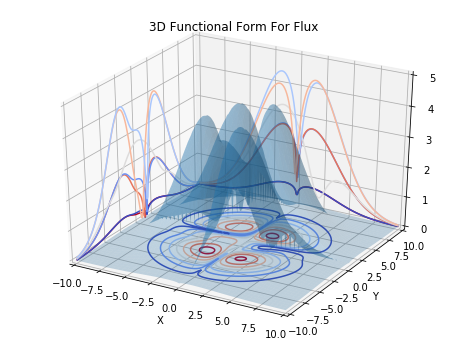

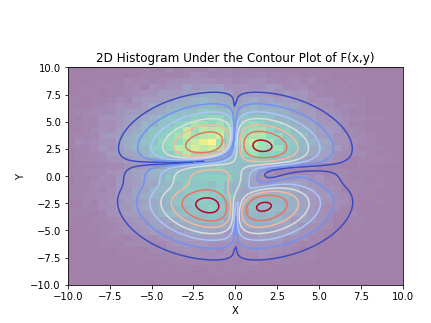

In [11]:
# Plot the analytic distribution and the sampling underneath it:
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
Z = flux(X, Y)
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.25)
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-10, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=10, cmap=cm.coolwarm)

ax.set_xlim3d(-10, 10);
ax.set_ylim3d(-10, 10);
ax.set_zlim3d(0, 5);
ax.set_title('3D Functional Form For Flux')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

# Plot only the contour plot:
plt.contour(X, Y, Z, cmap=cm.coolwarm)
plt.hist2d(samps[:,0], samps[:,1], normed=True, bins=50, alpha = 0.5)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.title('2D Histogram Under the Contour Plot of F(x,y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [12]:
def make_plots(samps, burnin, maxlags=100):
    fig, ax = plt.subplots(2,2, figsize=(12,6))
    maxlags = 100
    # Trace 1
    ax[0,0].plot(samps[burnin::,0])
    ax[0,0].set_title('Trace Plot of X Values')
    ax[0,0].set_xlabel('Iteration')
    ax[0,0].set_ylabel('Function Value')
    # Trace 2
    ax[0,1].plot(samps[burnin::,1])
    ax[0,1].set_title('Trace Plot of Y Values')
    ax[0,1].set_xlabel('Iteration')
    ax[0,1].set_ylabel('Function Value')
    # Autocorr 1
    ax[1,0].acorr(samps[:,0]-np.mean(samps[:,0]),  normed=True, maxlags=maxlags);
    ax[1,0].set_xlim([0, maxlags])
    ax[1,0].set_title('Autocorrelation of X values')
    ax[1,0].set_xlabel('Iteration')
    ax[1,0].set_ylabel('Function Value')
    # Autocorr 2
    ax[1,1].acorr(samps[:,1]-np.mean(samps[:,1]),  normed=True, maxlags=maxlags);
    ax[1,1].set_xlim([0, maxlags])
    ax[1,1].set_title('Autocorrelation of Y values')
    ax[1,1].set_xlabel('Iteration')
    ax[1,1].set_ylabel('Function Value')

    plt.tight_layout()
    plt.show()

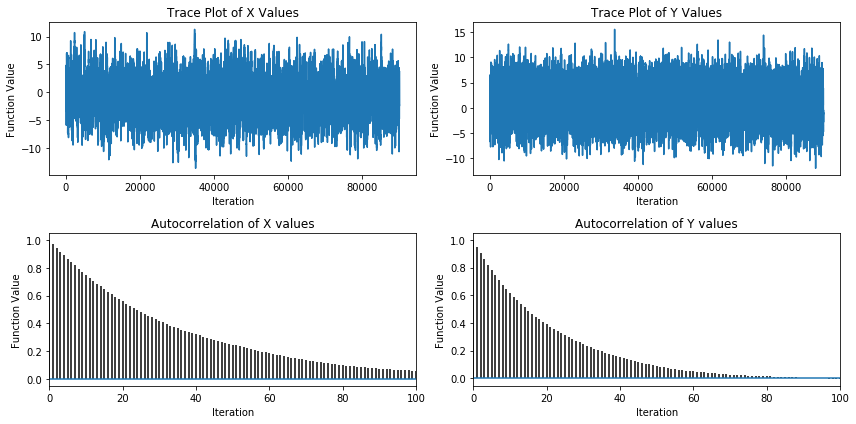

In [13]:
# Make the plots:
make_plots(samps,10000)

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?



Given that the beta shows up in an exponential fashion, it makes sense to do log spacing on the beta values between 0.1 to 40. As a result, we will get a better sense of the effect of a change in beta value on the result, rather than performing pure linear spacing

  2%|▏         | 1599/100000 [00:00<00:06, 15967.97it/s]

[  0.1          0.19458877   0.3786479    0.7368063    1.43374233
   2.78990159   5.42883523  10.5639038   20.55617066  40.        ]
Beta: 0.1


100%|██████████| 100000/100000 [00:05<00:00, 19024.13it/s]


Accepted Fraction: 0.21806


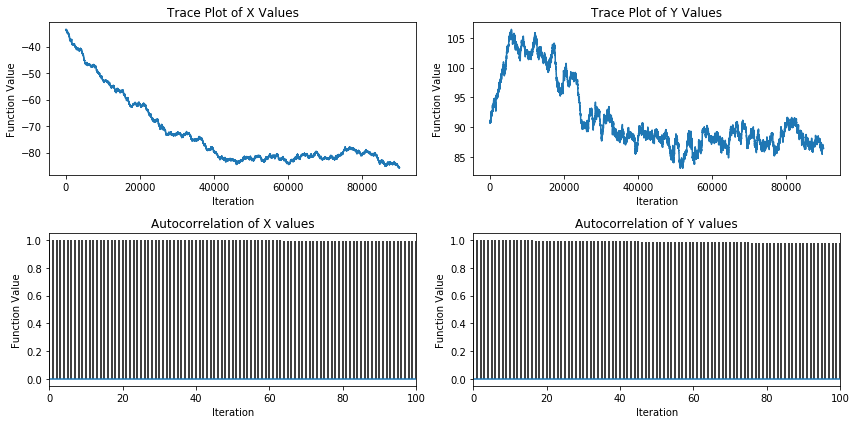

  3%|▎         | 3248/100000 [00:00<00:05, 16225.32it/s]

Beta: 0.194588771758


100%|██████████| 100000/100000 [00:05<00:00, 19933.67it/s]


Accepted Fraction: 0.53556


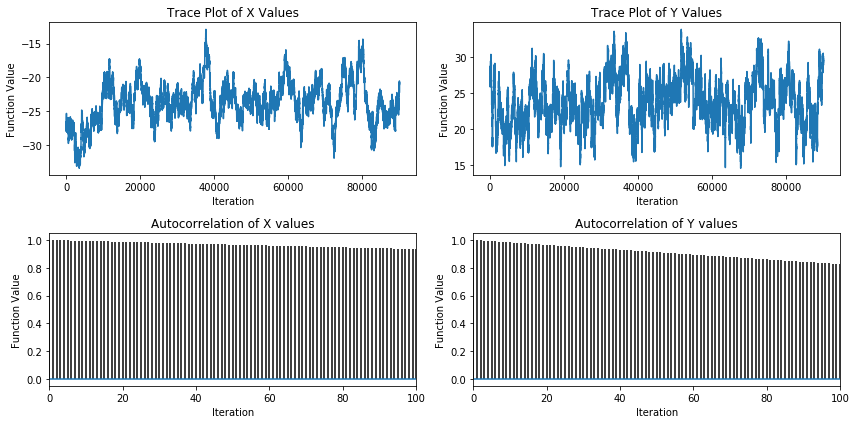

  1%|          | 1206/100000 [00:00<00:08, 12045.68it/s]

Beta: 0.378647900941


100%|██████████| 100000/100000 [00:05<00:00, 19914.21it/s]


Accepted Fraction: 0.73675


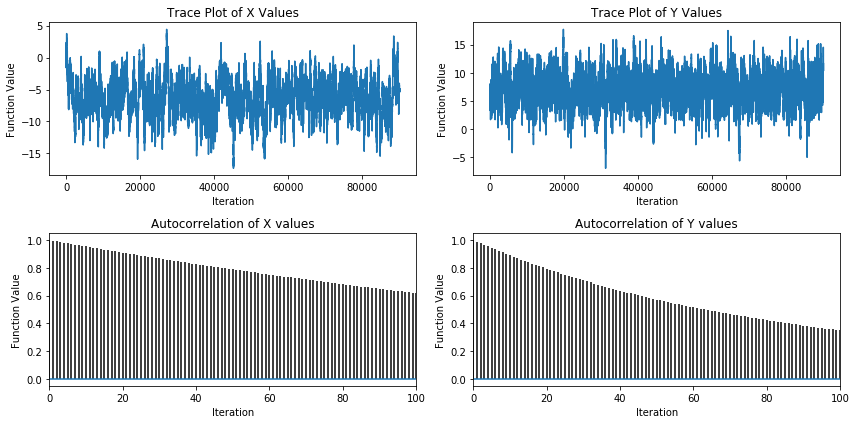

  2%|▏         | 1829/100000 [00:00<00:05, 18266.63it/s]

Beta: 0.736806299728


100%|██████████| 100000/100000 [00:05<00:00, 18965.89it/s]


Accepted Fraction: 0.79031


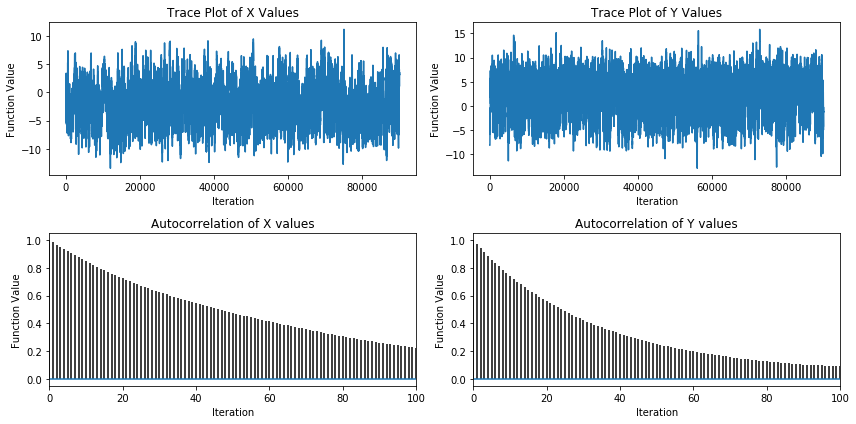

  2%|▏         | 1784/100000 [00:00<00:05, 17826.42it/s]

Beta: 1.43374232887


100%|██████████| 100000/100000 [00:05<00:00, 18869.18it/s]


Accepted Fraction: 0.70524


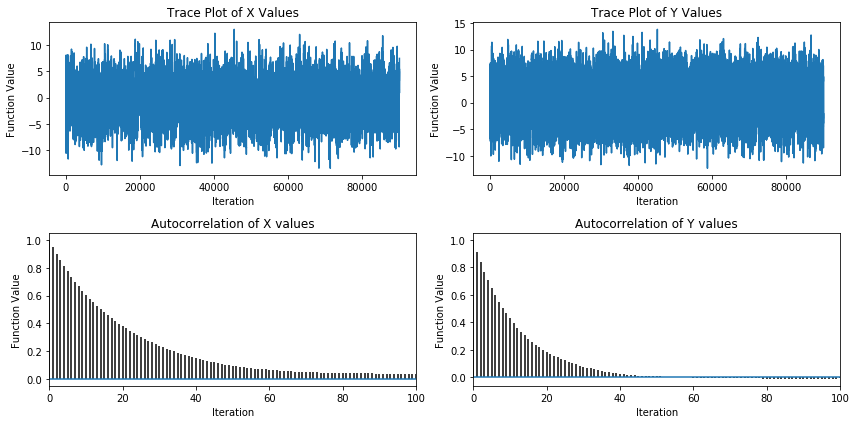

  3%|▎         | 3069/100000 [00:00<00:06, 15332.88it/s]

Beta: 2.78990158792


100%|██████████| 100000/100000 [00:05<00:00, 18356.78it/s]


Accepted Fraction: 0.54855


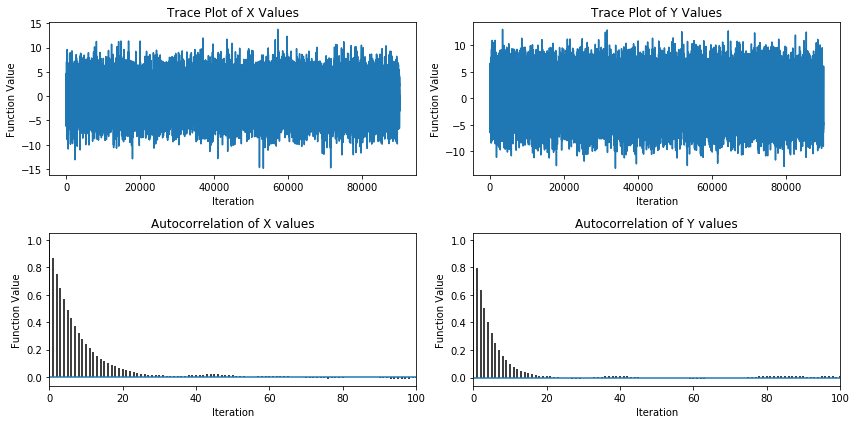

  3%|▎         | 3095/100000 [00:00<00:06, 15468.21it/s]

Beta: 5.42883523319


100%|██████████| 100000/100000 [00:05<00:00, 19399.01it/s]


Accepted Fraction: 0.31957


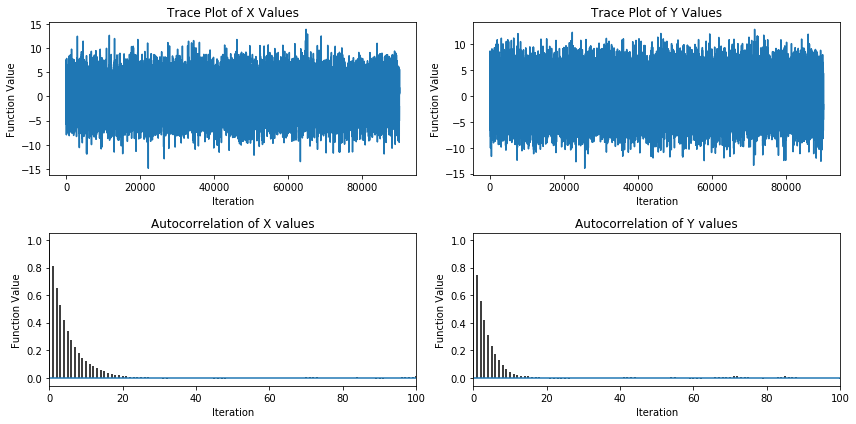

  3%|▎         | 2618/100000 [00:00<00:07, 13039.66it/s]

Beta: 10.563903801


100%|██████████| 100000/100000 [00:05<00:00, 19105.28it/s]


Accepted Fraction: 0.1272


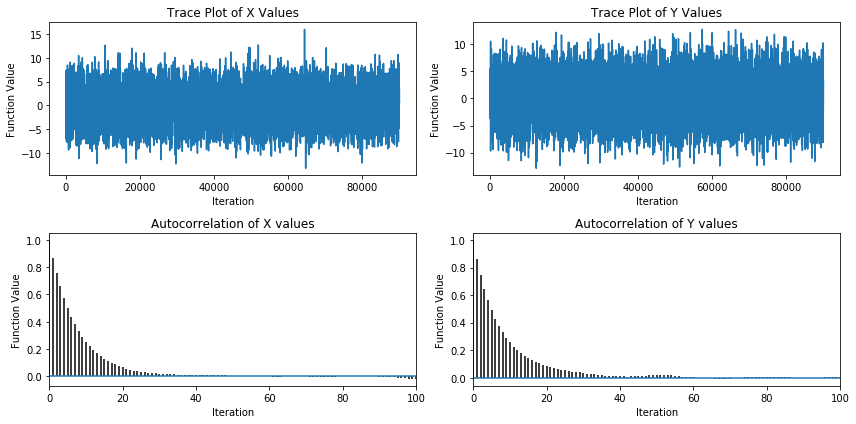

  2%|▏         | 1666/100000 [00:00<00:05, 16655.01it/s]

Beta: 20.556170656


100%|██████████| 100000/100000 [00:05<00:00, 18924.72it/s]


Accepted Fraction: 0.03848


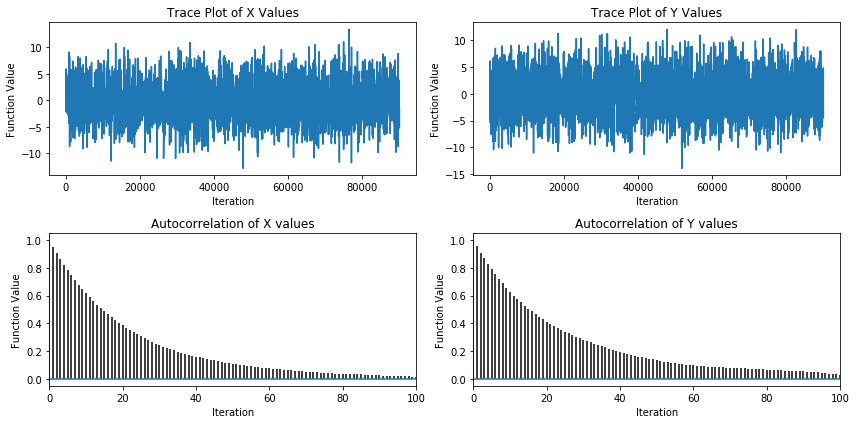

  2%|▏         | 1764/100000 [00:00<00:05, 17616.03it/s]

Beta: 40.0


100%|██████████| 100000/100000 [00:04<00:00, 20138.52it/s]


Accepted Fraction: 0.01055


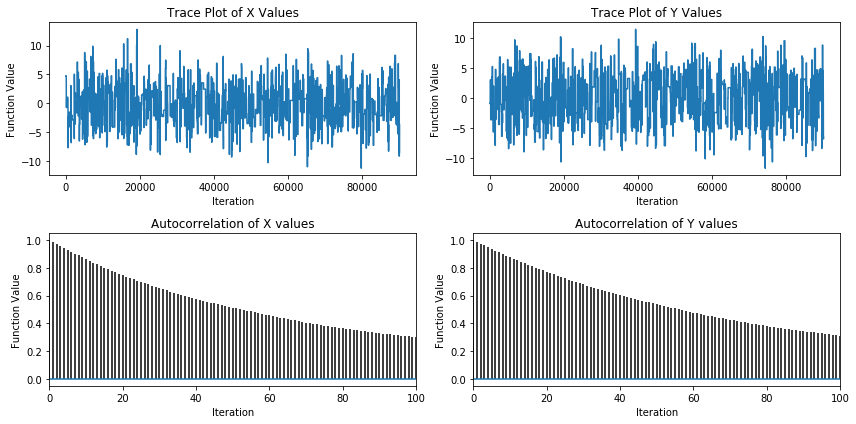

Accepted: [ 21806.  53556.  73675.  79031.  70524.  54855.  31957.  12720.   3848.
   1055.]


In [14]:
N = 10
burnin = 10000
betas = np.geomspace(0.1, 40, N)
print(betas)
accepted = np.empty(np.shape(betas))
# Run a loop over the beta values
for i, beta_val in enumerate(betas):
    print('Beta:', beta_val)
    x0 = [5, -5]
    samps, accepted[i] = metropolis_hastings(flux, qPDF, qDRAW, 100000, x0, beta=beta_val)  
    
    # Plot traces and autocorrelation
    make_plots(samps,burnin)
print('Accepted:', accepted)

Now we can analyze the different selections for beta and pick which is the best one. We see that a low value of beta has extremely large autocorrelation, and the trace plot does not behave as randomly as we might want or expect. After trying larger values of beta, we see that at intermediate beta values, we obtain a quick decay of the autocorrelation and a random pattern to the trace plot, however, when the beta values are increased higher, the autocorrelation returns and a pattern emerges to our trace plot. What happens in the large beta case is that the algorithm suggests very large step sizes, but the metropolis algorithm does not want to take these steps because the values of the function are likely extremely different for large steps. What results is that the algorithm will get stuck at one particular location for a long period of time before being able to jump out. As a result, we see a lot of autocorrelation from point to point. Finally, we should also look at the acceptance rates of each of algorithms, as we want a balance of taking audacious steps and also keeping it reasonable.

With all of this in mind, we can pick out an optimal beta value from our list of choices. In this particular example of N=10 beta values, we'll estimate that the best beta is the one that has sharply decreasing autocorrelation of both components and has a random pattern to the trace plot. In this case, that happens to be beta=2.78 which gives an acceptance rate of 50% and a sharply decreasing autocorrelation that dies out at around N=20

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

Let's now try the same process, but with a symmetric proposal function instead. To do so, we can simply remove the offset in the mean from the proposal function

In [15]:
# Define proposal function;
def qPDF_symm(Xnew, Xold, beta):
    g1 = 1.0*beta
    g2 = 1.5*beta
    Xstep = np.subtract(Xnew, Xold)
    q_out = np.exp( -((Xstep[0])**2/(2*g1**2) + (Xstep[0])**2/(2*g2**2)) )
    return(q_out)

# Define q draw:
def qDRAW_symm(Xold, beta):
    g1 = 1.0*beta
    g2 = 1.5*beta
    Xstep = [np.random.normal(loc=0, scale=g1), np.random.normal(loc=0, scale=g2) ]
    
    Xnew = np.add(Xold, Xstep)
    return(Xnew)

  2%|▏         | 1844/100000 [00:00<00:05, 18432.63it/s]

[  0.1          0.19458877   0.3786479    0.7368063    1.43374233
   2.78990159   5.42883523  10.5639038   20.55617066  40.        ]
Beta: 0.1


100%|██████████| 100000/100000 [00:05<00:00, 18155.31it/s]


Accepted Fraction: 0.97277


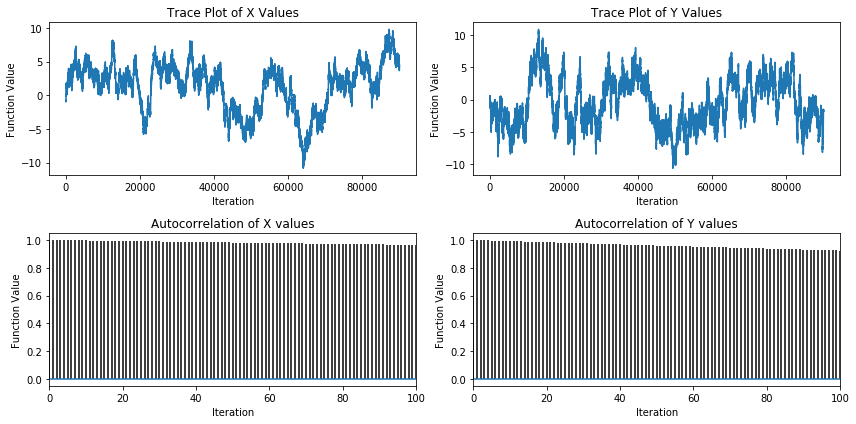

  2%|▏         | 2479/100000 [00:00<00:07, 12358.30it/s]

Beta: 0.194588771758


100%|██████████| 100000/100000 [00:05<00:00, 18738.22it/s]


Accepted Fraction: 0.94619


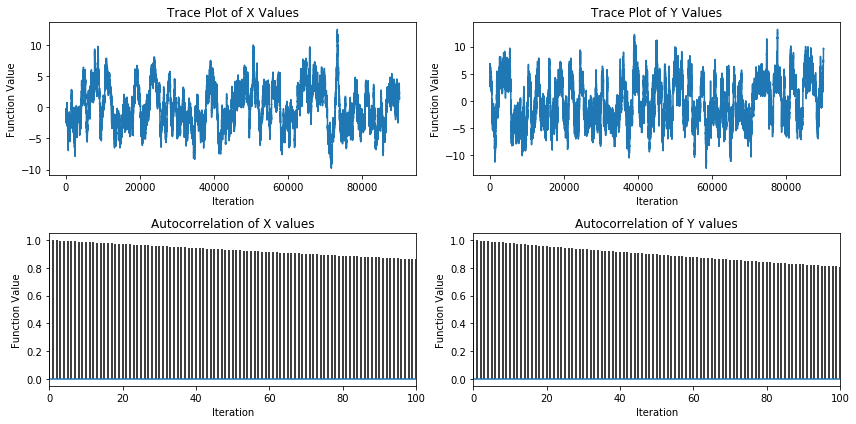

  2%|▏         | 1541/100000 [00:00<00:06, 15164.06it/s]

Beta: 0.378647900941


100%|██████████| 100000/100000 [00:05<00:00, 18940.34it/s]


Accepted Fraction: 0.90013


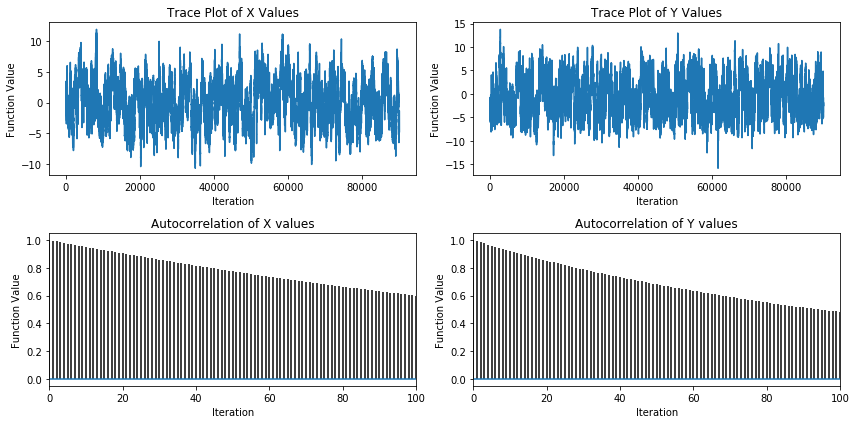

  3%|▎         | 3181/100000 [00:00<00:06, 15866.05it/s]

Beta: 0.736806299728


100%|██████████| 100000/100000 [00:04<00:00, 20156.49it/s]


Accepted Fraction: 0.82424


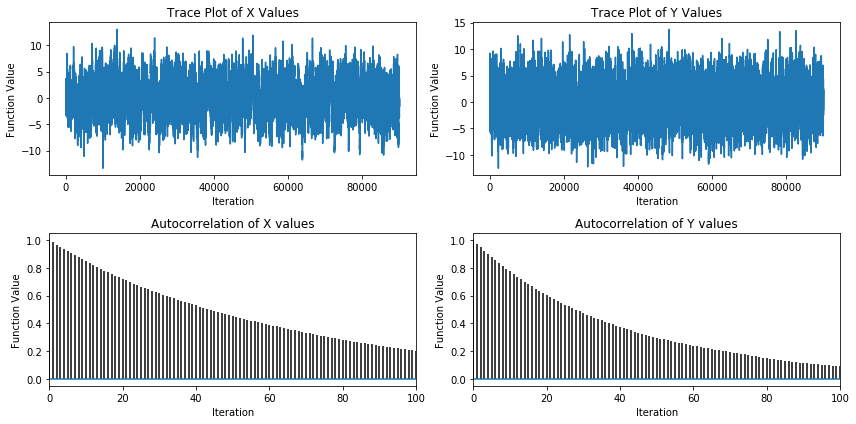

  3%|▎         | 3039/100000 [00:00<00:06, 15188.86it/s]

Beta: 1.43374232887


100%|██████████| 100000/100000 [00:04<00:00, 20377.59it/s]


Accepted Fraction: 0.71126


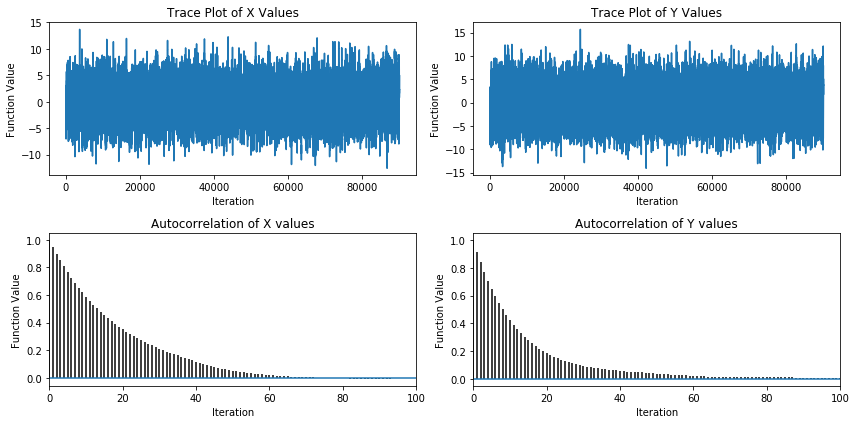

  1%|▏         | 1295/100000 [00:00<00:07, 12943.69it/s]

Beta: 2.78990158792


100%|██████████| 100000/100000 [00:05<00:00, 19900.53it/s]


Accepted Fraction: 0.55069


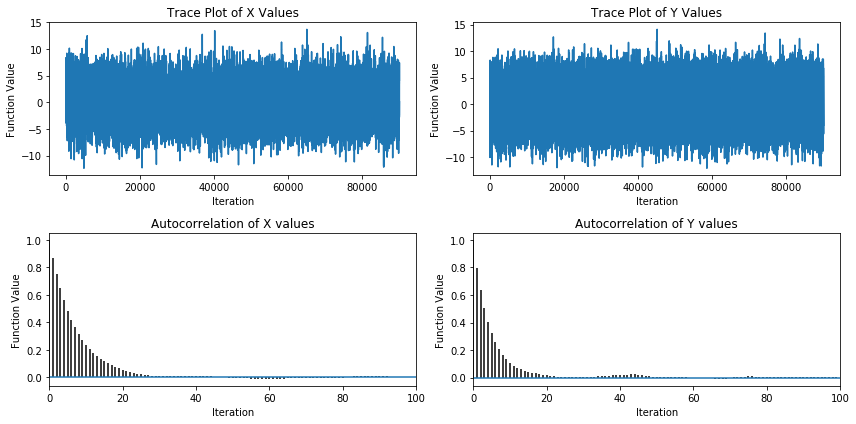

  2%|▏         | 1545/100000 [00:00<00:06, 15433.97it/s]

Beta: 5.42883523319


100%|██████████| 100000/100000 [00:05<00:00, 19666.77it/s]


Accepted Fraction: 0.31878


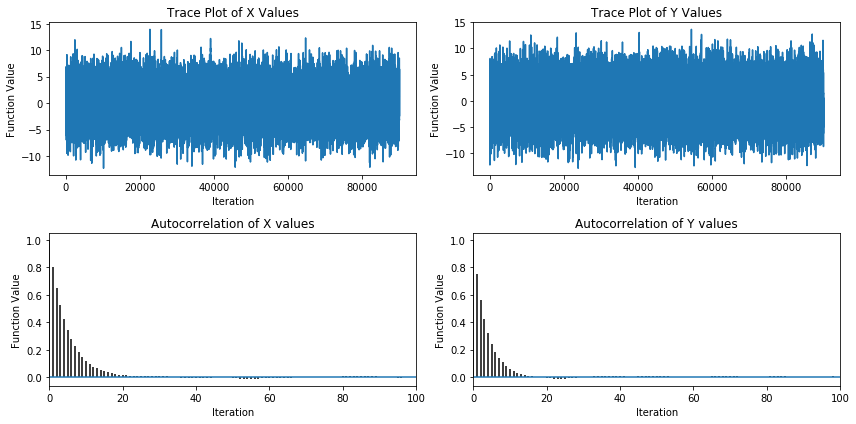

  3%|▎         | 2696/100000 [00:00<00:07, 13474.13it/s]

Beta: 10.563903801


100%|██████████| 100000/100000 [00:05<00:00, 19851.25it/s]


Accepted Fraction: 0.12773


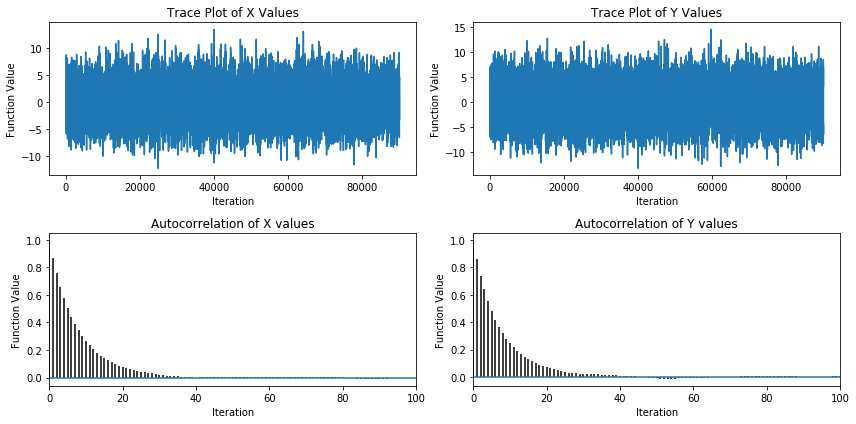

  2%|▏         | 1774/100000 [00:00<00:05, 17678.31it/s]

Beta: 20.556170656


100%|██████████| 100000/100000 [00:05<00:00, 19511.03it/s]


Accepted Fraction: 0.03961


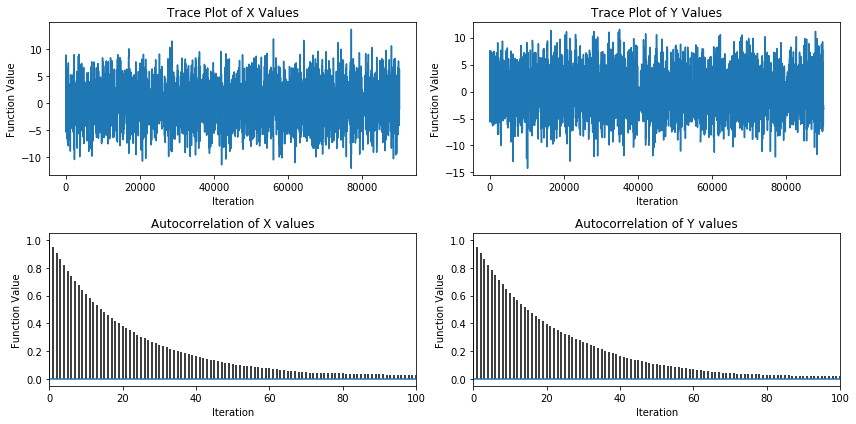

  2%|▏         | 2143/100000 [00:00<00:09, 10708.84it/s]

Beta: 40.0


100%|██████████| 100000/100000 [00:05<00:00, 18914.65it/s]


Accepted Fraction: 0.01037


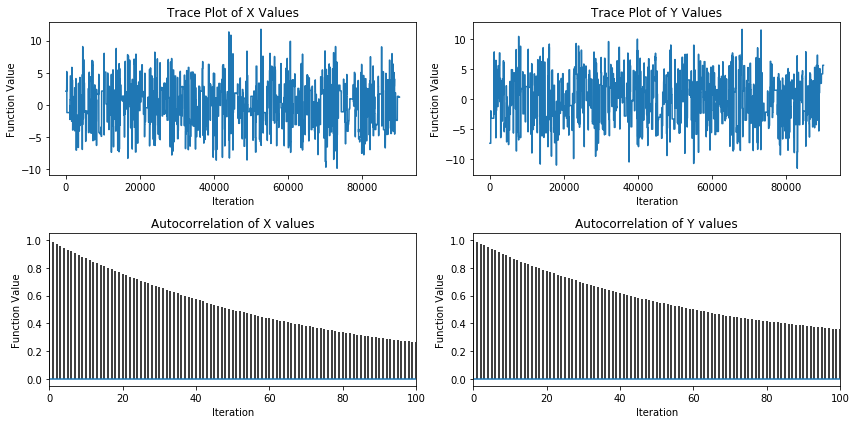

In [17]:
N = 10
burnin = 10000
betas = np.geomspace(0.1, 40, N)
print(betas)
accepted_symm = np.empty(np.shape(betas))
# Run a loop over the beta values
for i, beta_val in enumerate(betas):
    print('Beta:', beta_val)
    x0 = [5, -5]
    samps, accepted_symm[i] = metropolis_hastings(flux, qPDF_symm, qDRAW_symm, 100000, x0, beta=beta_val)  
    
    # Plot traces and autocorrelation
    make_plots(samps,burnin)

In [18]:
# Let's print out the accepted values for each of the two cases and compare:
print('Best:\n', betas)
print('Asymmetric Accepted:\n', accepted/100000)
print('Symmetric Accepted:\n', accepted_symm/100000)

Best:
 [  0.1          0.19458877   0.3786479    0.7368063    1.43374233
   2.78990159   5.42883523  10.5639038   20.55617066  40.        ]
Asymmetric Accepted:
 [ 0.21806  0.53556  0.73675  0.79031  0.70524  0.54855  0.31957  0.1272
  0.03848  0.01055]
Symmetric Accepted:
 [ 0.97277  0.94619  0.90013  0.82424  0.71126  0.55069  0.31878  0.12773
  0.03961  0.01037]


Now we should compare the results of the two different proposal functions. We first of all notice that the accepted fractions are nearly exactly equal in both cases. This is the purpose of the Metropolis-Hastings - in other words, the Hastings algorithm generates the correction needed to counteract the asymmetry. We see a similar trend in all of the autocorrelation and trace plots and extract the optimal value of beta in both cases to be about the same.